In [1]:
#pip install tensorflow

In [2]:
#pip install --upgrade pip

In [3]:
%matplotlib inline
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("prepared_Forex_GBPUSD.csv")


In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close
0,2005-01-03,1.919791,1.919791,1.900490,1.904617,1.904617
1,2005-01-04,1.904617,1.908506,1.878816,1.883594,1.883594
2,2005-01-05,1.883594,1.889216,1.873712,1.885512,1.885512
3,2005-01-06,1.885690,1.885690,1.870802,1.876490,1.876490
4,2005-01-07,1.876595,1.886010,1.865811,1.871293,1.871293


In [5]:
df.Date=  pd.to_datetime(df['Date'])

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close
0,2005-01-03,1.919791,1.919791,1.900490,1.904617,1.904617
1,2005-01-04,1.904617,1.908506,1.878816,1.883594,1.883594
2,2005-01-05,1.883594,1.889216,1.873712,1.885512,1.885512
3,2005-01-06,1.885690,1.885690,1.870802,1.876490,1.876490
4,2005-01-07,1.876595,1.886010,1.865811,1.871293,1.871293


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6753 entries, 0 to 6752
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6753 non-null   datetime64[ns]
 1   Open       6753 non-null   float64       
 2   High       6753 non-null   float64       
 3   Low        6753 non-null   float64       
 4   Close      6753 non-null   float64       
 5   Adj Close  6753 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 316.7 KB


In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close
0,2005-01-03,1.919791,1.919791,1.900490,1.904617,1.904617
1,2005-01-04,1.904617,1.908506,1.878816,1.883594,1.883594
2,2005-01-05,1.883594,1.889216,1.873712,1.885512,1.885512
3,2005-01-06,1.885690,1.885690,1.870802,1.876490,1.876490
4,2005-01-07,1.876595,1.886010,1.865811,1.871293,1.871293


In [9]:
df = df.set_index("Date")

In [10]:
df.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2005-01-03,1.919791,1.919791,1.900490,1.904617,1.904617
2005-01-04,1.904617,1.908506,1.878816,1.883594,1.883594
2005-01-05,1.883594,1.889216,1.873712,1.885512,1.885512
2005-01-06,1.885690,1.885690,1.870802,1.876490,1.876490
2005-01-07,1.876595,1.886010,1.865811,1.871293,1.871293


Visualize the data

Text(0.5, 1.0, 'Daily GBP/USD Close Rate')

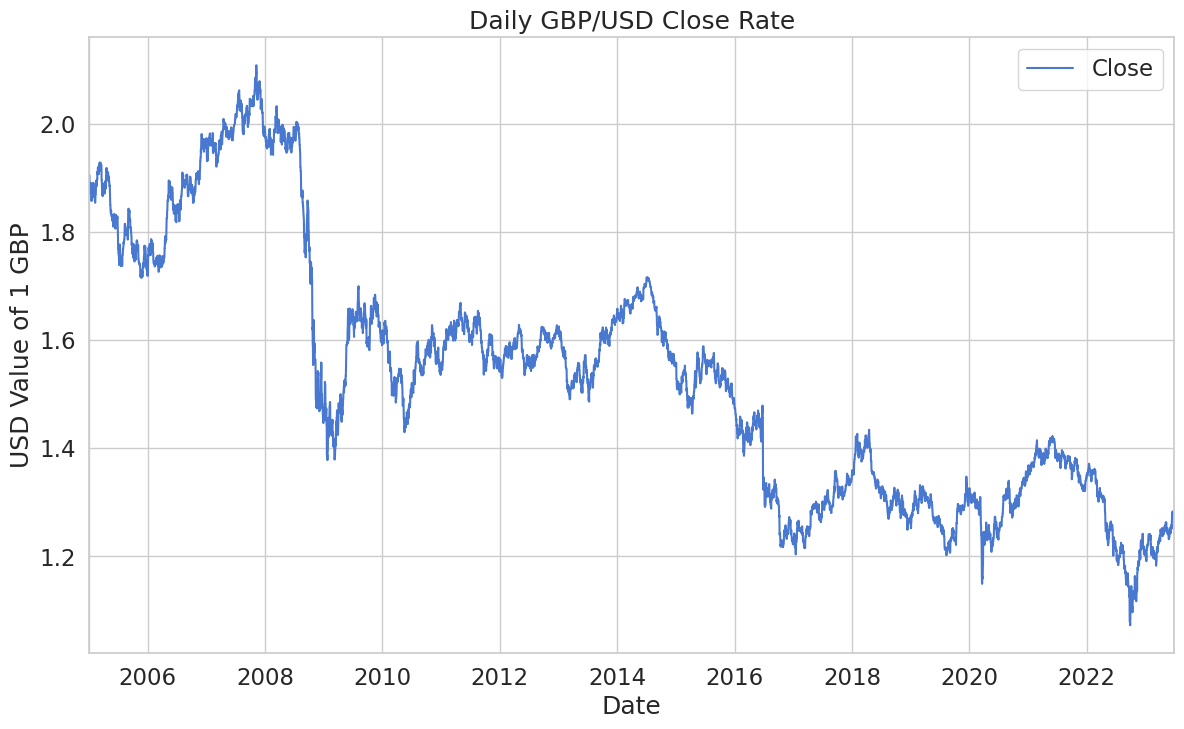

In [11]:
rcParams['figure.figsize'] = 14, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# data plot
ax = df.plot(y='Close');
ax.set_xlabel('Date')
ax.set_ylabel('USD Value of 1 GBP')
ax.set_title('Daily GBP/USD Close Rate')

Create the Model

In [12]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# Setting the random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Extract features and target (Close column)
features = df[['Open', 'High', 'Low', 'Adj Close', 'Close']].values

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

seq_len = 30

def split_into_sequences(arr, seq_len):
    n_seq = len(arr) - seq_len + 1
    return np.array([arr[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(arr, seq_len, train_frac):
    sequences = split_into_sequences(arr, seq_len)

    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :-1]  # Exclude the Close column for input sequences
    y_train = sequences[:n_train, -1, -1]    # Set the Close column for the target
    x_test = sequences[n_train:, :-1, :-1]
    y_test = sequences[n_train:, -1, -1]

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_features, seq_len, train_frac=0.8)

y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Fraction of the input to drop to help prevent overfitting
dropout = 0.3
window_size = seq_len - 1

# Build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True,
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
model.add(
    LSTM((window_size * 2), return_sequences=True)
)

model.add(Dropout(rate=dropout))
model.add(
    LSTM(window_size, return_sequences=False)
)

model.add(Dense(units=1))
model.add(Activation('linear'))


batch_size = 32
learning_rate = 0.001

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    loss='mean_squared_error',
    optimizer=optimizer
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/50
135/135 [==============================] - 12s 16ms/step - loss: 0.0193 - val_loss: 0.0017
Epoch 2/50
135/135 [==============================] - 1s 9ms/step - loss: 0.0085 - val_loss: 0.0013
Epoch 3/50
135/135 [==============================] - 1s 9ms/step - loss: 0.0099 - val_loss: 0.0013
Epoch 4/50
135/135 [==============================] - 1s 9ms/step - loss: 0.0118 - val_loss: 9.1294e-04
Epoch 5/50
135/135 [==============================] - 1s 9ms/step - loss: 0.0130 - val_loss: 2.9625e-04
Epoch 6/50
135/135 [==============================] - 1s 9ms/step - loss: 0.0127 - val_loss: 2.6865e-04
Epoch 7/50
135/135 [==============================] - 1s 10ms/step - loss: 0.0113 - val_loss: 8.1758e-04
Epoch 8/50
135/135 [==============================] - 1s 9ms/step - loss: 0.0107 - val_loss: 6.3657e-04
Epoch 9/50
135/135 [==============================] - 1s 9ms/step - loss: 0.0120 - val_loss: 4.1678e-04
Epoch 10/50
135/135 [==============================] - 1s 8ms/step - loss

Plotting training and validation loss

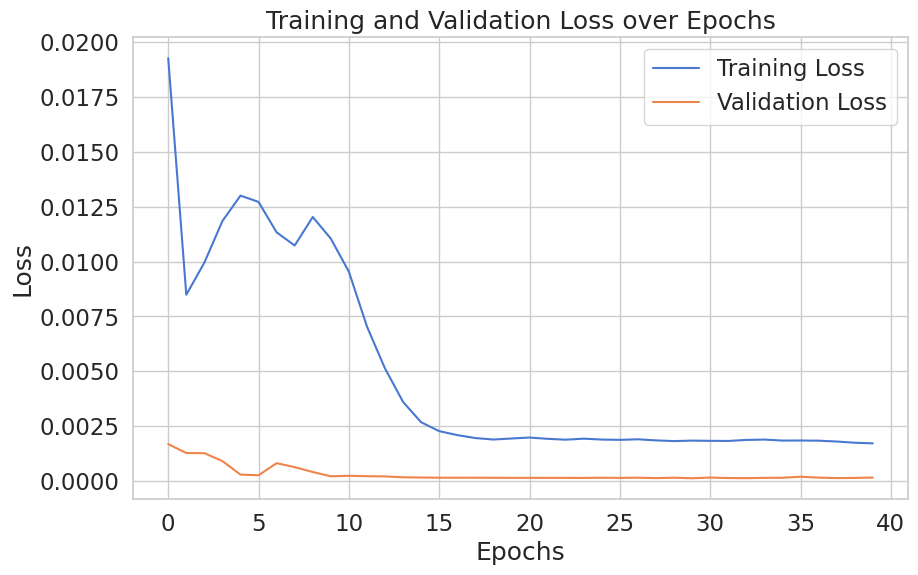

In [13]:

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Prediction

43/43 [==============================] - 1s 3ms/step


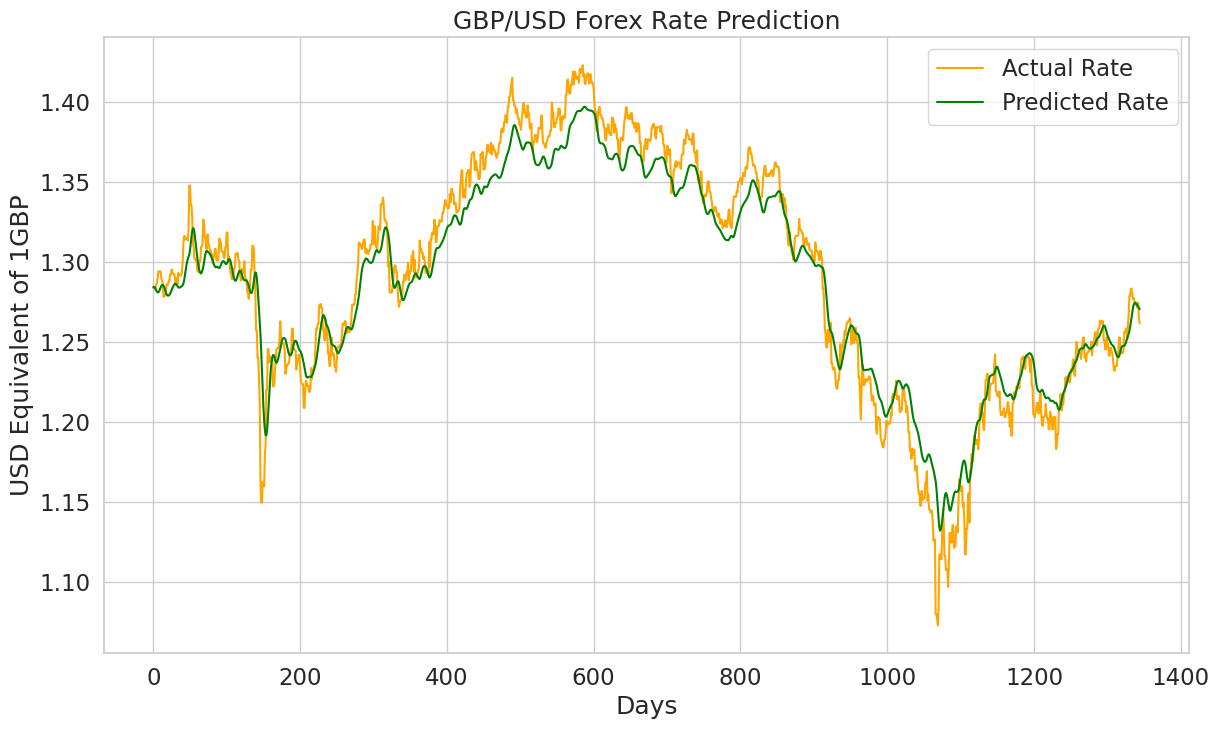

In [14]:
y_pred = model.predict(x_test)

# To invert the scaler, we create a placeholder array with the same shape as 'scaled_features'.
placeholder_array_test = np.zeros((len(y_test), scaled_features.shape[1]))
placeholder_array_pred = np.zeros((len(y_pred), scaled_features.shape[1]))

# Insert the y_test and y_pred data into the last column of the placeholder arrays
placeholder_array_test[:,-1] = y_test[:,0]
placeholder_array_pred[:,-1] = y_pred[:,0]

# Invert the scaler to get the absolute rate data
y_test_orig = scaler.inverse_transform(placeholder_array_test)[:,-1]
y_pred_orig = scaler.inverse_transform(placeholder_array_pred)[:,-1]

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual Rate', color='orange')
plt.plot(y_pred_orig, label='Predicted Rate', color='green')

plt.title('GBP/USD Forex Rate Prediction')
plt.xlabel('Days')
plt.ylabel('USD Equivalent of 1GBP')
plt.legend(loc='best')

plt.show()


Complete plot

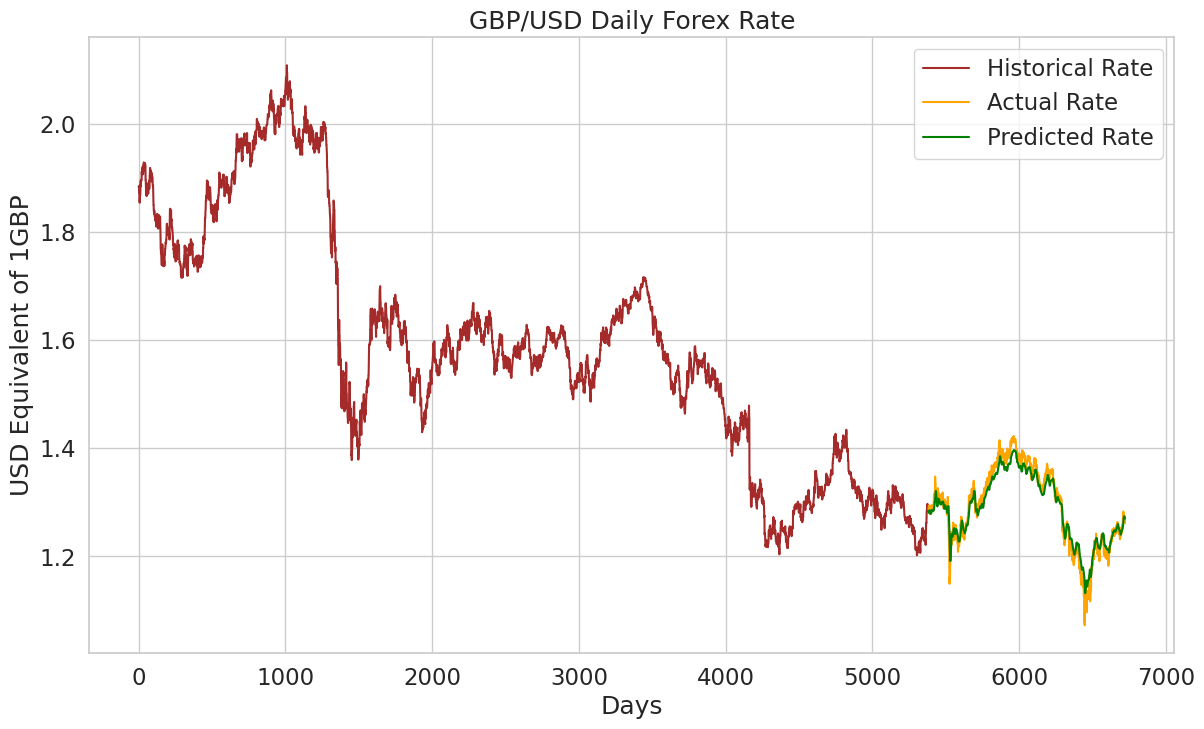

In [15]:
# Prepare a placeholder array for y_train for the inverse transformation
placeholder_array_train = np.zeros((len(y_train), scaled_features.shape[1]))
placeholder_array_train[:,-1] = y_train[:,0]
y_train_orig = scaler.inverse_transform(placeholder_array_train)[:,-1]

# Plot for the entire range of data
plt.plot(np.arange(0, len(y_train)), y_train_orig, color='brown', label='Historical Rate')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Rate')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Rate')

plt.title('GBP/USD Daily Forex Rate')
plt.xlabel('Days')
plt.ylabel('USD Equivalent of 1GBP')
plt.legend()
plt.show()


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 29, 29)            3944      
                                                                 
 dropout (Dropout)           (None, 29, 29)            0         
                                                                 
 lstm_1 (LSTM)               (None, 29, 58)            20416     
                                                                 
 dropout_1 (Dropout)         (None, 29, 58)            0         
                                                                 
 lstm_2 (LSTM)               (None, 29)                10208     
                                                                 
 dense (Dense)               (None, 1)                 30        
                                                                 
 activation (Activation)     (None, 1)                 0

In [17]:
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

print("Param:", seq_len, batch_size)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Param: 30 32
Mean Squared Error (MSE): 0.0003014160302665236
Root Mean Squared Error (RMSE): 0.017361337225758954
Mean Absolute Error (MAE): 0.01361519641227649
R-squared (R2) Score: 0.9446105085701783
